=== Overall Statistics ===
Total evaluations: 595
Overall accuracy: 61.34%

=== Accuracy by Compression ===
                  is_correct       
                       count   mean
compression_index                  
0                        100  0.710
1                         99  0.677
2                         99  0.626
3                         99  0.606
4                         99  0.495
5                         99  0.566

=== Character Count Reduction ===
                   percent_of_original
compression_index                     
0                                100.0
1                                 54.3
2                                 40.8
3                                 31.7
4                                 23.5
5                                 13.9


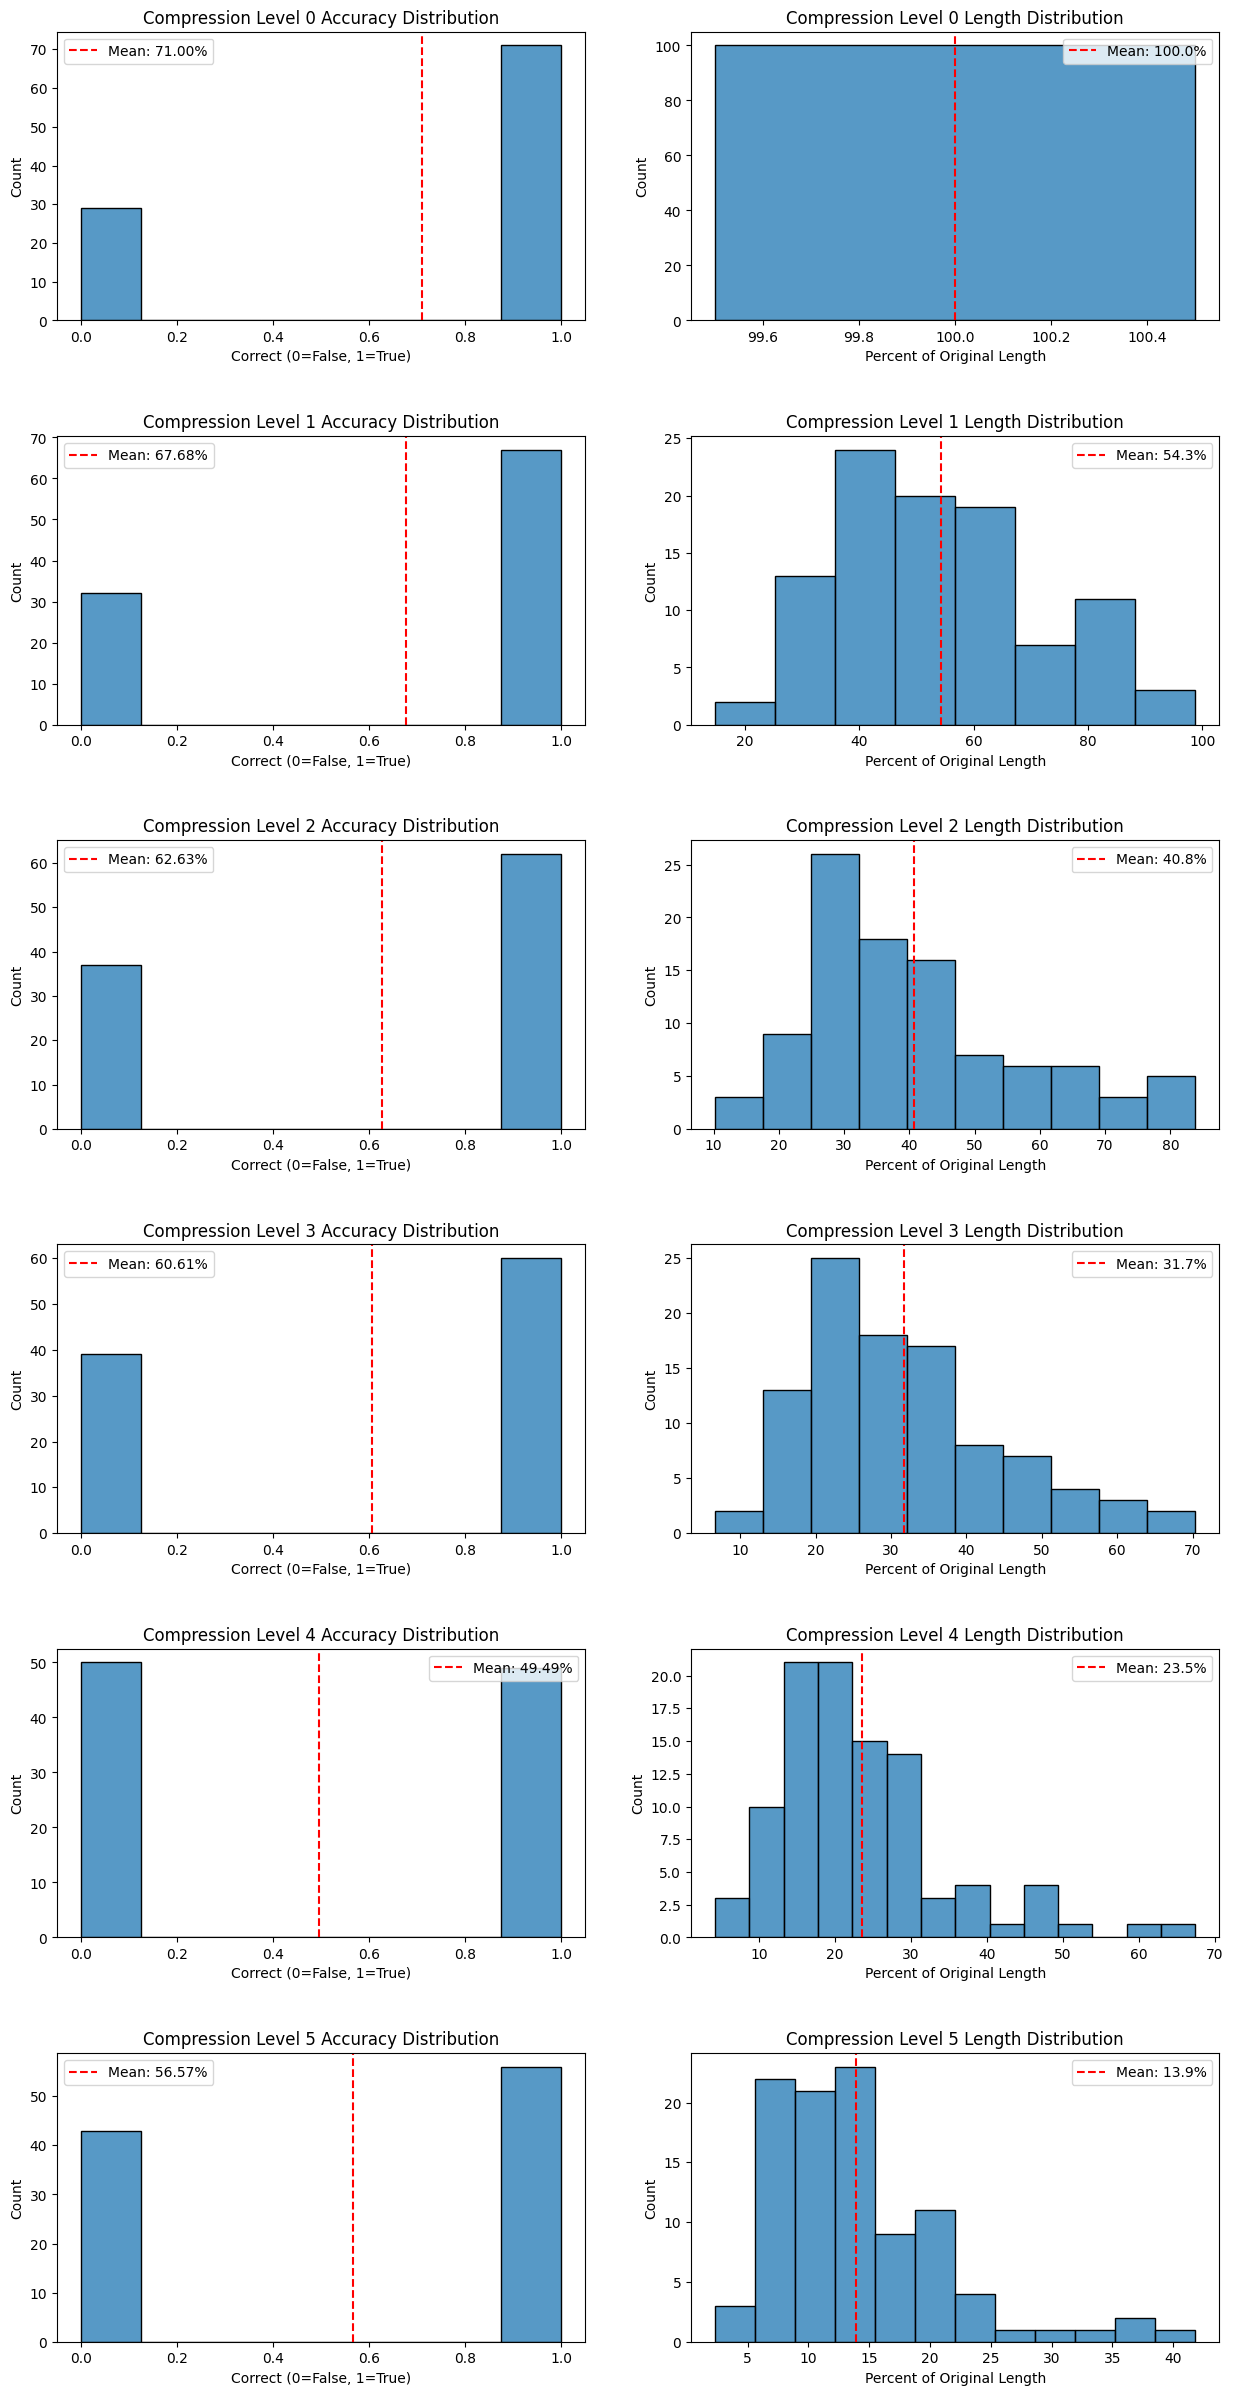

/var/folders/pn/ctr6tfqn77556nyp3p9v447r0000gn/T/ipykernel_16813/4184626425.py:70: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=combined_df, x='compression_index', y='is_correct',


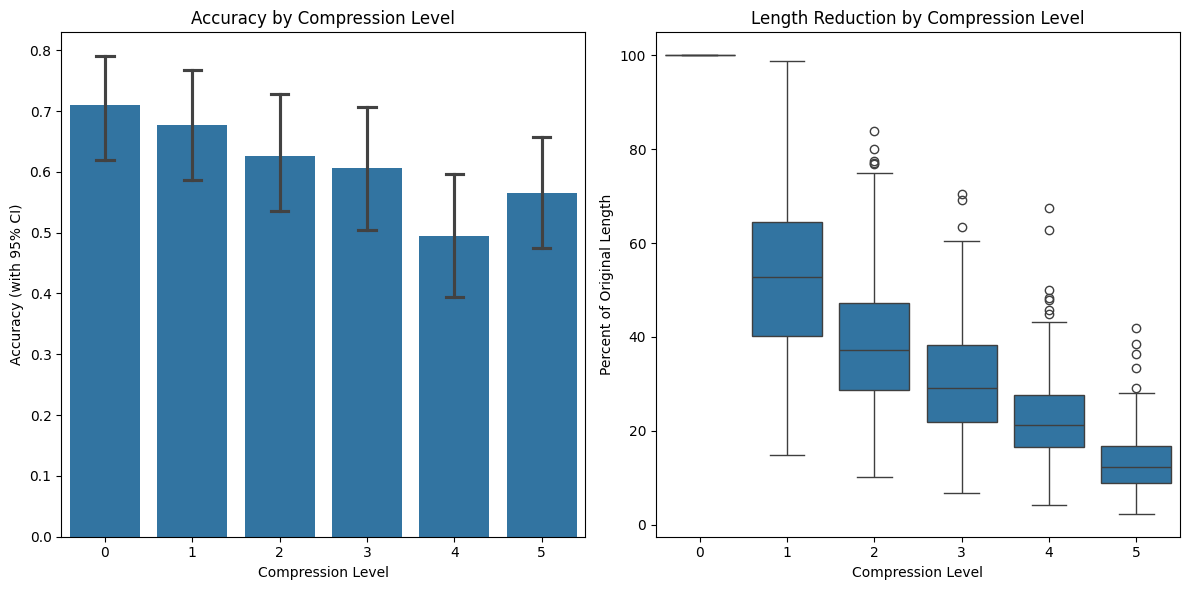


=== Per-Process Statistics ===
            Total Evaluations  Accuracy  Unique Questions
process_id                                               
0                         150     0.653                25
1                         150     0.687                25
2                         145     0.572                25
3                         150     0.540                25


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load all process results
timestamp = "20250130_195708"  # Change this if needed
dfs = []
for i in range(4):
    df = pd.read_csv(f'../results_{timestamp}_process_{i}.csv')
    df['process_id'] = i  # Add process ID for tracking
    dfs.append(df)

# Combine all results
combined_df = pd.concat(dfs, ignore_index=True)

# Basic statistics
print("=== Overall Statistics ===")
print(f"Total evaluations: {len(combined_df)}")
print(f"Overall accuracy: {combined_df['is_correct'].mean():.2%}")

# Accuracy by compression level
print("\n=== Accuracy by Compression ===")
compression_accuracy = combined_df.groupby('compression_index').agg({
    'is_correct': ['count', 'mean']
}).round(3)
print(compression_accuracy)

# Character count reduction
print("\n=== Character Count Reduction ===")
char_reduction = combined_df.groupby('compression_index').agg({
    'percent_of_original': 'mean'
}).round(1)
print(char_reduction)

# Create subplots for each compression level
num_compressions = combined_df['compression_index'].nunique()
fig, axes = plt.subplots(num_compressions, 2, figsize=(15, 5*num_compressions))
plt.subplots_adjust(hspace=0.4)

for idx in range(num_compressions):
    compression_data = combined_df[combined_df['compression_index'] == idx]
    
    # Plot 1: Accuracy histogram
    ax1 = axes[idx, 0]
    accuracy = compression_data['is_correct'].mean()
    sns.histplot(data=compression_data, x='is_correct', ax=ax1)
    ax1.axvline(accuracy, color='r', linestyle='--', label=f'Mean: {accuracy:.2%}')
    ax1.set_title(f'Compression Level {idx} Accuracy Distribution')
    ax1.set_xlabel('Correct (0=False, 1=True)')
    ax1.set_ylabel('Count')
    ax1.legend()

    # Plot 2: Character length distribution
    ax2 = axes[idx, 1]
    mean_percent = compression_data['percent_of_original'].mean()
    sns.histplot(data=compression_data, x='percent_of_original', ax=ax2)
    ax2.axvline(mean_percent, color='r', linestyle='--', label=f'Mean: {mean_percent:.1f}%')
    ax2.set_title(f'Compression Level {idx} Length Distribution')
    ax2.set_xlabel('Percent of Original Length')
    ax2.set_ylabel('Count')
    ax2.legend()

plt.show()

# Summary plot
plt.figure(figsize=(12, 6))

# Plot accuracy vs compression level with error bars
plt.subplot(1, 2, 1)
sns.barplot(data=combined_df, x='compression_index', y='is_correct', 
            ci=95, capsize=.2)
plt.title('Accuracy by Compression Level')
plt.xlabel('Compression Level')
plt.ylabel('Accuracy (with 95% CI)')

# Plot average length reduction
plt.subplot(1, 2, 2)
sns.boxplot(data=combined_df, x='compression_index', y='percent_of_original')
plt.title('Length Reduction by Compression Level')
plt.xlabel('Compression Level')
plt.ylabel('Percent of Original Length')

plt.tight_layout()
plt.show()

# Per-process statistics
print("\n=== Per-Process Statistics ===")
process_stats = combined_df.groupby('process_id').agg({
    'is_correct': ['count', 'mean'],
    'record_id': 'nunique'
}).round(3)
process_stats.columns = ['Total Evaluations', 'Accuracy', 'Unique Questions']
print(process_stats)

# Save combined results if needed
combined_df.to_csv(f'results_{timestamp}_combined.csv', index=False)

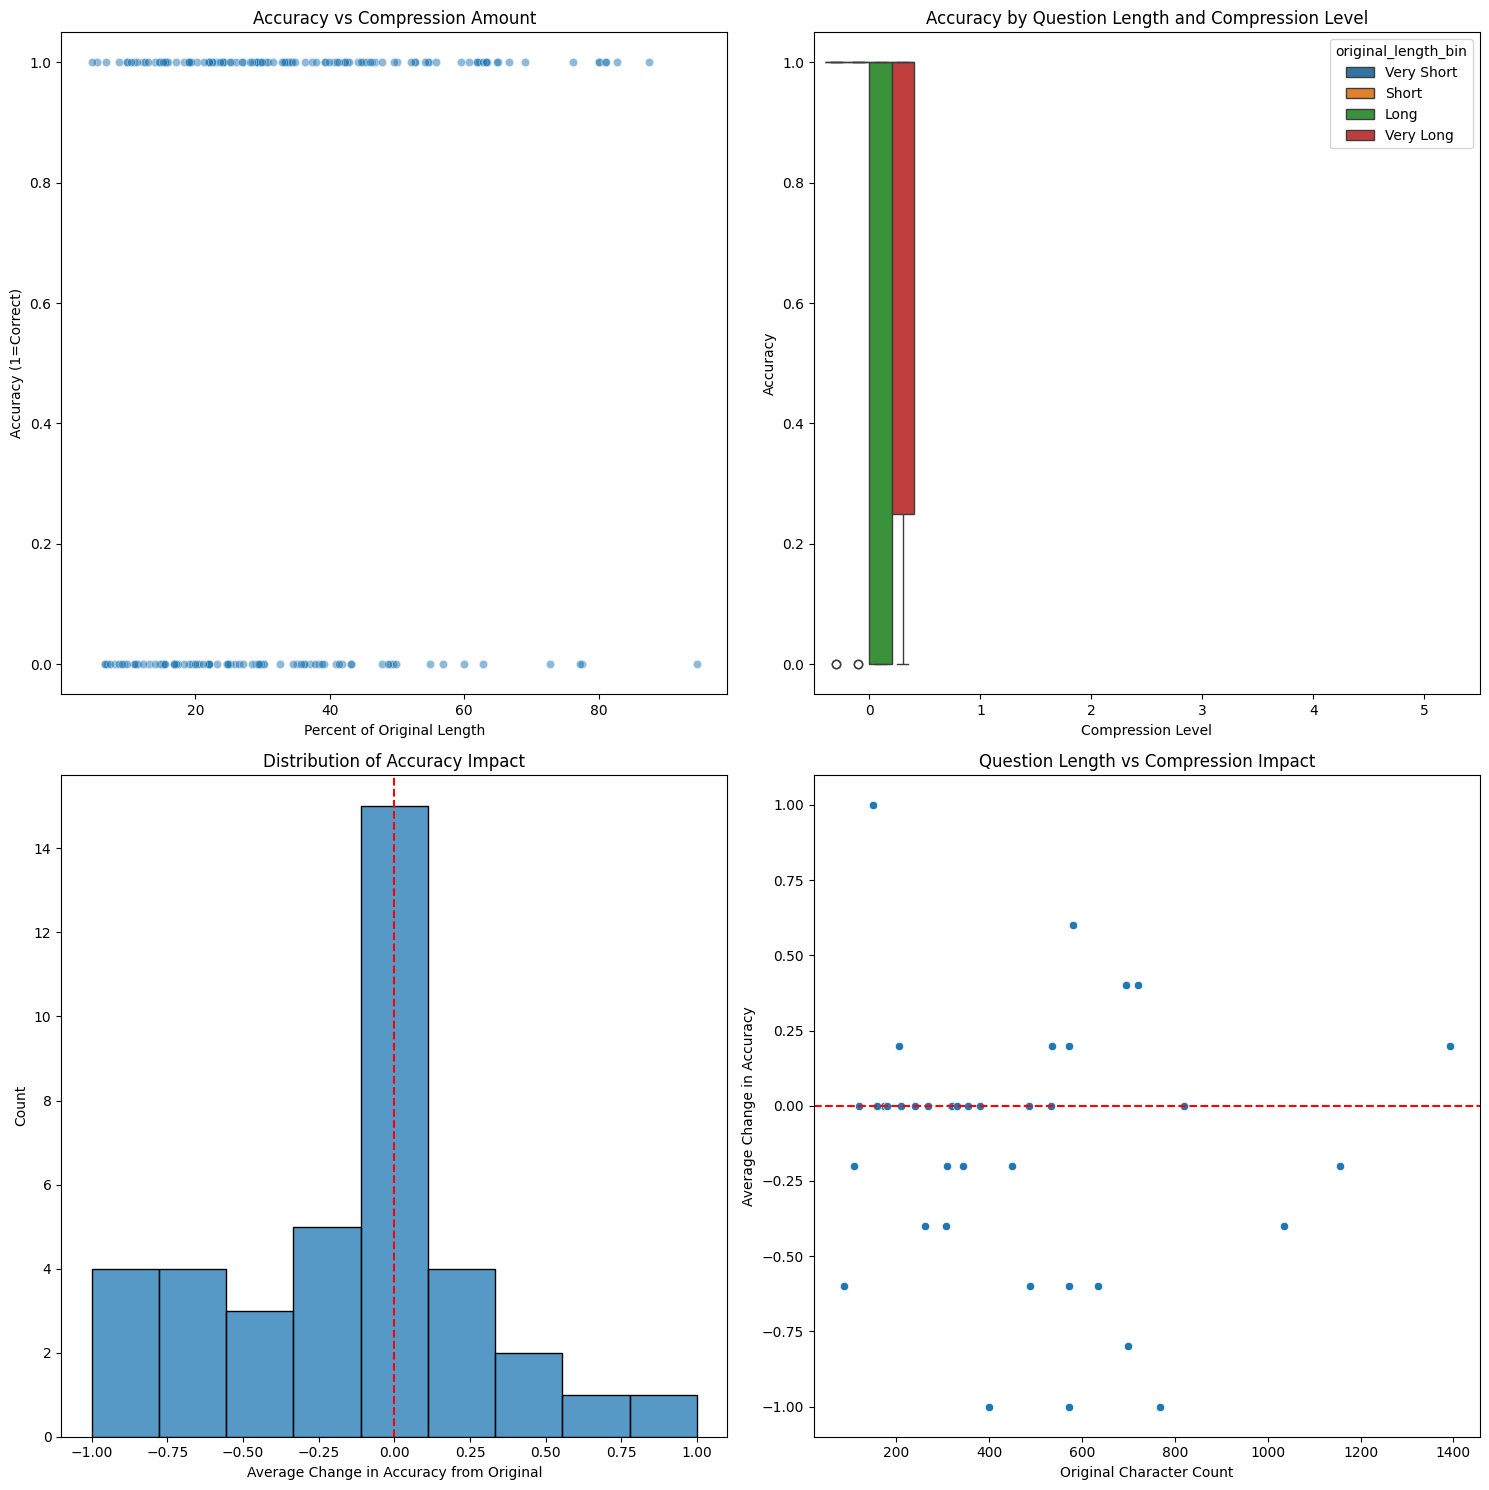


=== Question Resilience Analysis ===

Most Resilient Questions (maintained or improved accuracy):
            record_id  is_correct  original_char_count
21  reccVFW11Elovnf8T         0.2                 1392
4   rec1zl5LvaatzGhFt         0.0                  819
24  receYQxnUBvxPcvbQ         0.4                  721
28  recgM7o1tcc7tP778         0.4                  695
36  recyl3usDqb7ruXJx         0.6                  581

Least Resilient Questions (largest accuracy drop):
            record_id  is_correct  original_char_count
11  recKv4hFyNpViUXnL        -1.0                  769
31  recvlnu8BuLmXZhSX        -1.0                  400
39  reczUoM8JsxU6pYxr        -1.0                  571
33  recxTy0x7M6T9ikc0        -0.8                  700
17  recNAiPUKOulQbKVP        -0.6                   88

Accuracy Change by Length Category:
length_bin
Very Short    0.040000
Short        -0.120000
Long         -0.240000
Very Long    -0.222222
Name: is_correct, dtype: float64


/var/folders/pn/ctr6tfqn77556nyp3p9v447r0000gn/T/ipykernel_16813/1611910844.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(question_stats.groupby('length_bin')['is_correct'].mean())


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load and combine data as before
# ...

# 1. Create length bins for original questions
combined_df['original_length_bin'] = pd.qcut(
    combined_df[combined_df['compression_index'] == 0]['original_char_count'], 
    q=4, 
    labels=['Very Short', 'Short', 'Long', 'Very Long']
)

# 2. Calculate compression resilience
# First, get baseline accuracy for each question
question_baseline = combined_df[combined_df['compression_index'] == 0].set_index('record_id')['is_correct']

# Calculate accuracy drop relative to baseline
resilience_df = combined_df.groupby(['record_id', 'compression_index']).agg({
    'is_correct': 'first',
    'percent_of_original': 'first',
    'original_char_count': 'first'
}).reset_index()

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Plot 1: Accuracy vs Percent of Original Length
sns.scatterplot(
    data=combined_df[combined_df['compression_index'] > 0],  # Exclude original
    x='percent_of_original', 
    y='is_correct',
    alpha=0.5,
    ax=ax1
)
ax1.set_title('Accuracy vs Compression Amount')
ax1.set_xlabel('Percent of Original Length')
ax1.set_ylabel('Accuracy (1=Correct)')

# Plot 2: Accuracy by Length Bin and Compression Level
sns.boxplot(
    data=combined_df,
    x='compression_index',
    y='is_correct',
    hue='original_length_bin',
    ax=ax2
)
ax2.set_title('Accuracy by Question Length and Compression Level')
ax2.set_xlabel('Compression Level')
ax2.set_ylabel('Accuracy')

# Plot 3: Compression Impact Distribution
question_stats = combined_df.groupby('record_id').agg({
    'is_correct': lambda x: x.iloc[1:].mean() - x.iloc[0],  # Average change from baseline
    'original_char_count': 'first'
}).reset_index()

sns.histplot(
    data=question_stats,
    x='is_correct',
    ax=ax3
)
ax3.set_title('Distribution of Accuracy Impact')
ax3.set_xlabel('Average Change in Accuracy from Original')
ax3.axvline(x=0, color='r', linestyle='--')

# Plot 4: Original Length vs Compression Impact
sns.scatterplot(
    data=question_stats,
    x='original_char_count',
    y='is_correct',
    ax=ax4
)
ax4.set_title('Question Length vs Compression Impact')
ax4.set_xlabel('Original Character Count')
ax4.set_ylabel('Average Change in Accuracy')
ax4.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Print some statistics
print("\n=== Question Resilience Analysis ===")
print("\nMost Resilient Questions (maintained or improved accuracy):")
resilient_questions = question_stats[question_stats['is_correct'] >= 0].sort_values('original_char_count', ascending=False).head()
print(resilient_questions)

print("\nLeast Resilient Questions (largest accuracy drop):")
vulnerable_questions = question_stats[question_stats['is_correct'] < 0].sort_values('is_correct').head()
print(vulnerable_questions)

# Length bin analysis
print("\nAccuracy Change by Length Category:")
question_stats['length_bin'] = pd.qcut(question_stats['original_char_count'], q=4, labels=['Very Short', 'Short', 'Long', 'Very Long'])
print(question_stats.groupby('length_bin')['is_correct'].mean())

Character count boundaries for each group:
Very Short: (225.8, 347.8]
Short: (347.8, 513.4]
Medium: (79.999, 225.8]
Long: (610.0, 1642.0]
Very Long: (513.4, 610.0]

Accuracy by length group and compression level:
                                 mean  count    std
length_group compression_index                     
Very Short   0                  0.792     24  0.415
             1                  0.917     24  0.282
             2                  0.792     24  0.415
             3                  0.792     24  0.415
             4                  0.792     24  0.415
             5                  0.708     24  0.464
Short        0                  0.750     24  0.442
             1                  0.708     24  0.464
             2                  0.583     24  0.504
             3                  0.708     24  0.464
             4                  0.583     24  0.504
             5                  0.583     24  0.504
Medium       0                  0.583     24  0.504
       

/var/folders/pn/ctr6tfqn77556nyp3p9v447r0000gn/T/ipykernel_16813/1121393524.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_group = combined_df.groupby(['length_group', 'compression_index'])['is_correct'].agg(['mean', 'count', 'std']).round(3)
/var/folders/pn/ctr6tfqn77556nyp3p9v447r0000gn/T/ipykernel_16813/1121393524.py:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


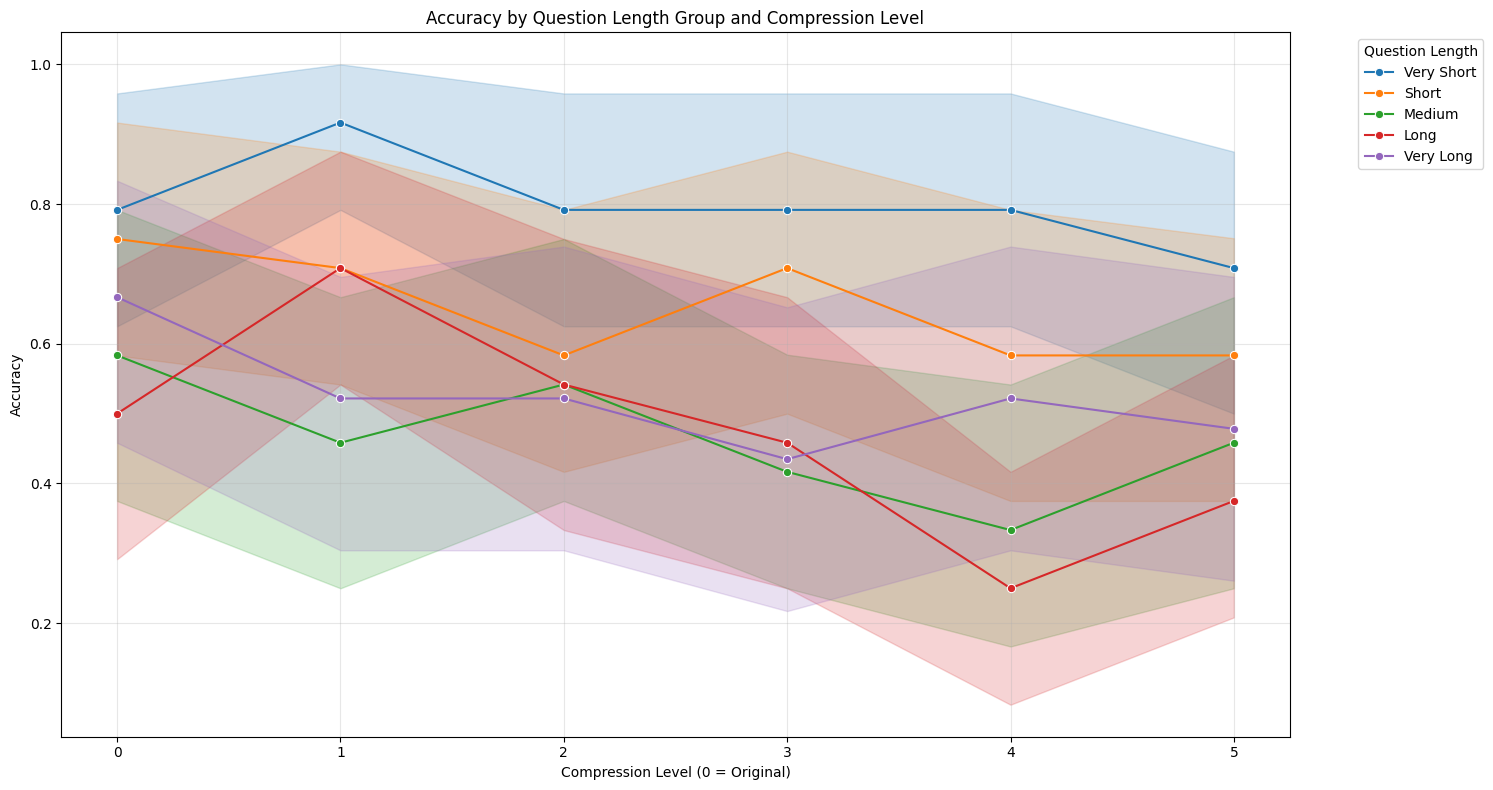


Detailed statistics for each group:

Very Short Questions:
Character count range: 80 to 225
Number of questions: 24
Accuracy by compression level:
compression_index
0    0.792
1    0.917
2    0.792
3    0.792
4    0.792
5    0.708
Name: is_correct, dtype: float64

Short Questions:
Character count range: 226 to 343
Number of questions: 24
Accuracy by compression level:
compression_index
0    0.750
1    0.708
2    0.583
3    0.708
4    0.583
5    0.583
Name: is_correct, dtype: float64

Medium Questions:
Character count range: 351 to 513
Number of questions: 24
Accuracy by compression level:
compression_index
0    0.583
1    0.458
2    0.542
3    0.417
4    0.333
5    0.458
Name: is_correct, dtype: float64

Long Questions:
Character count range: 514 to 604
Number of questions: 24
Accuracy by compression level:
compression_index
0    0.500
1    0.708
2    0.542
3    0.458
4    0.250
5    0.375
Name: is_correct, dtype: float64

Very Long Questions:
Character count range: 634 to 1642
Number

/var/folders/pn/ctr6tfqn77556nyp3p9v447r0000gn/T/ipykernel_16813/1121393524.py:71: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = combined_df.pivot_table(


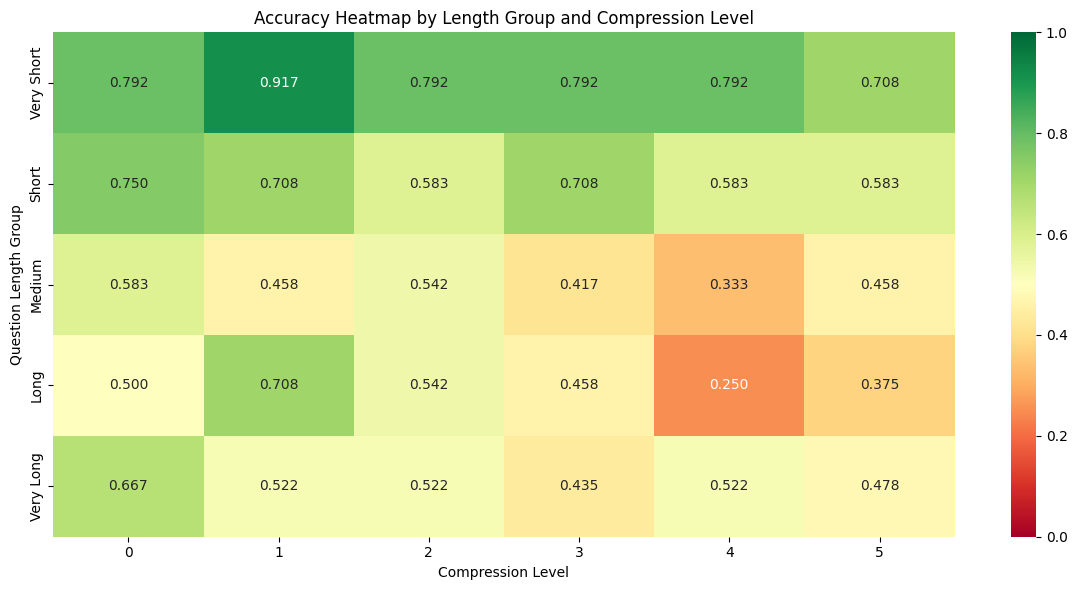

In [30]:
# Load all process results
timestamp = "20250130_195708"
dfs = []
for i in range(4):
    df = pd.read_csv(f'../results_{timestamp}_process_{i}.csv')
    df['process_id'] = i
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# Get original questions only to determine length groups
original_questions = combined_df[combined_df['compression_index'] == 0].copy()

# Create 5 length groups using quantiles for equal-sized groups
original_questions['length_group'] = pd.qcut(
    original_questions['original_char_count'],
    q=5,
    labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
)

# Get the boundary values for our groups
boundaries = pd.qcut(original_questions['original_char_count'], q=5).unique()
print("Character count boundaries for each group:")
for i, boundary in enumerate(boundaries):
    print(f"{['Very Short', 'Short', 'Medium', 'Long', 'Very Long'][i]}: {boundary}")

# Add length groups back to main dataframe
length_groups = original_questions[['record_id', 'length_group']]
combined_df = combined_df.merge(length_groups, on='record_id')

# Calculate accuracy by length group and compression level
accuracy_by_group = combined_df.groupby(['length_group', 'compression_index'])['is_correct'].agg(['mean', 'count', 'std']).round(3)
print("\nAccuracy by length group and compression level:")
print(accuracy_by_group)

# Plotting
plt.figure(figsize=(15, 8))

# Plot accuracy for each length group
sns.lineplot(
    data=combined_df,
    x='compression_index',
    y='is_correct',
    hue='length_group',
    marker='o',
    ci=95
)

plt.title('Accuracy by Question Length Group and Compression Level')
plt.xlabel('Compression Level (0 = Original)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend(title='Question Length', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

# Additional statistics
print("\nDetailed statistics for each group:")
for group in ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']:
    group_data = combined_df[combined_df['length_group'] == group]
    print(f"\n{group} Questions:")
    print(f"Character count range: {group_data['original_char_count'].min():.0f} to {group_data['original_char_count'].max():.0f}")
    print(f"Number of questions: {len(group_data[group_data['compression_index'] == 0])}")
    print("Accuracy by compression level:")
    print(group_data.groupby('compression_index')['is_correct'].mean().round(3))
    
# Create a heatmap of accuracies
plt.figure(figsize=(12, 6))
heatmap_data = combined_df.pivot_table(
    values='is_correct',
    index='length_group',
    columns='compression_index',
    aggfunc='mean'
)

sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlGn',
            center=0.5,
            vmin=0,
            vmax=1)
plt.title('Accuracy Heatmap by Length Group and Compression Level')
plt.xlabel('Compression Level')
plt.ylabel('Question Length Group')
plt.tight_layout()
plt.show()

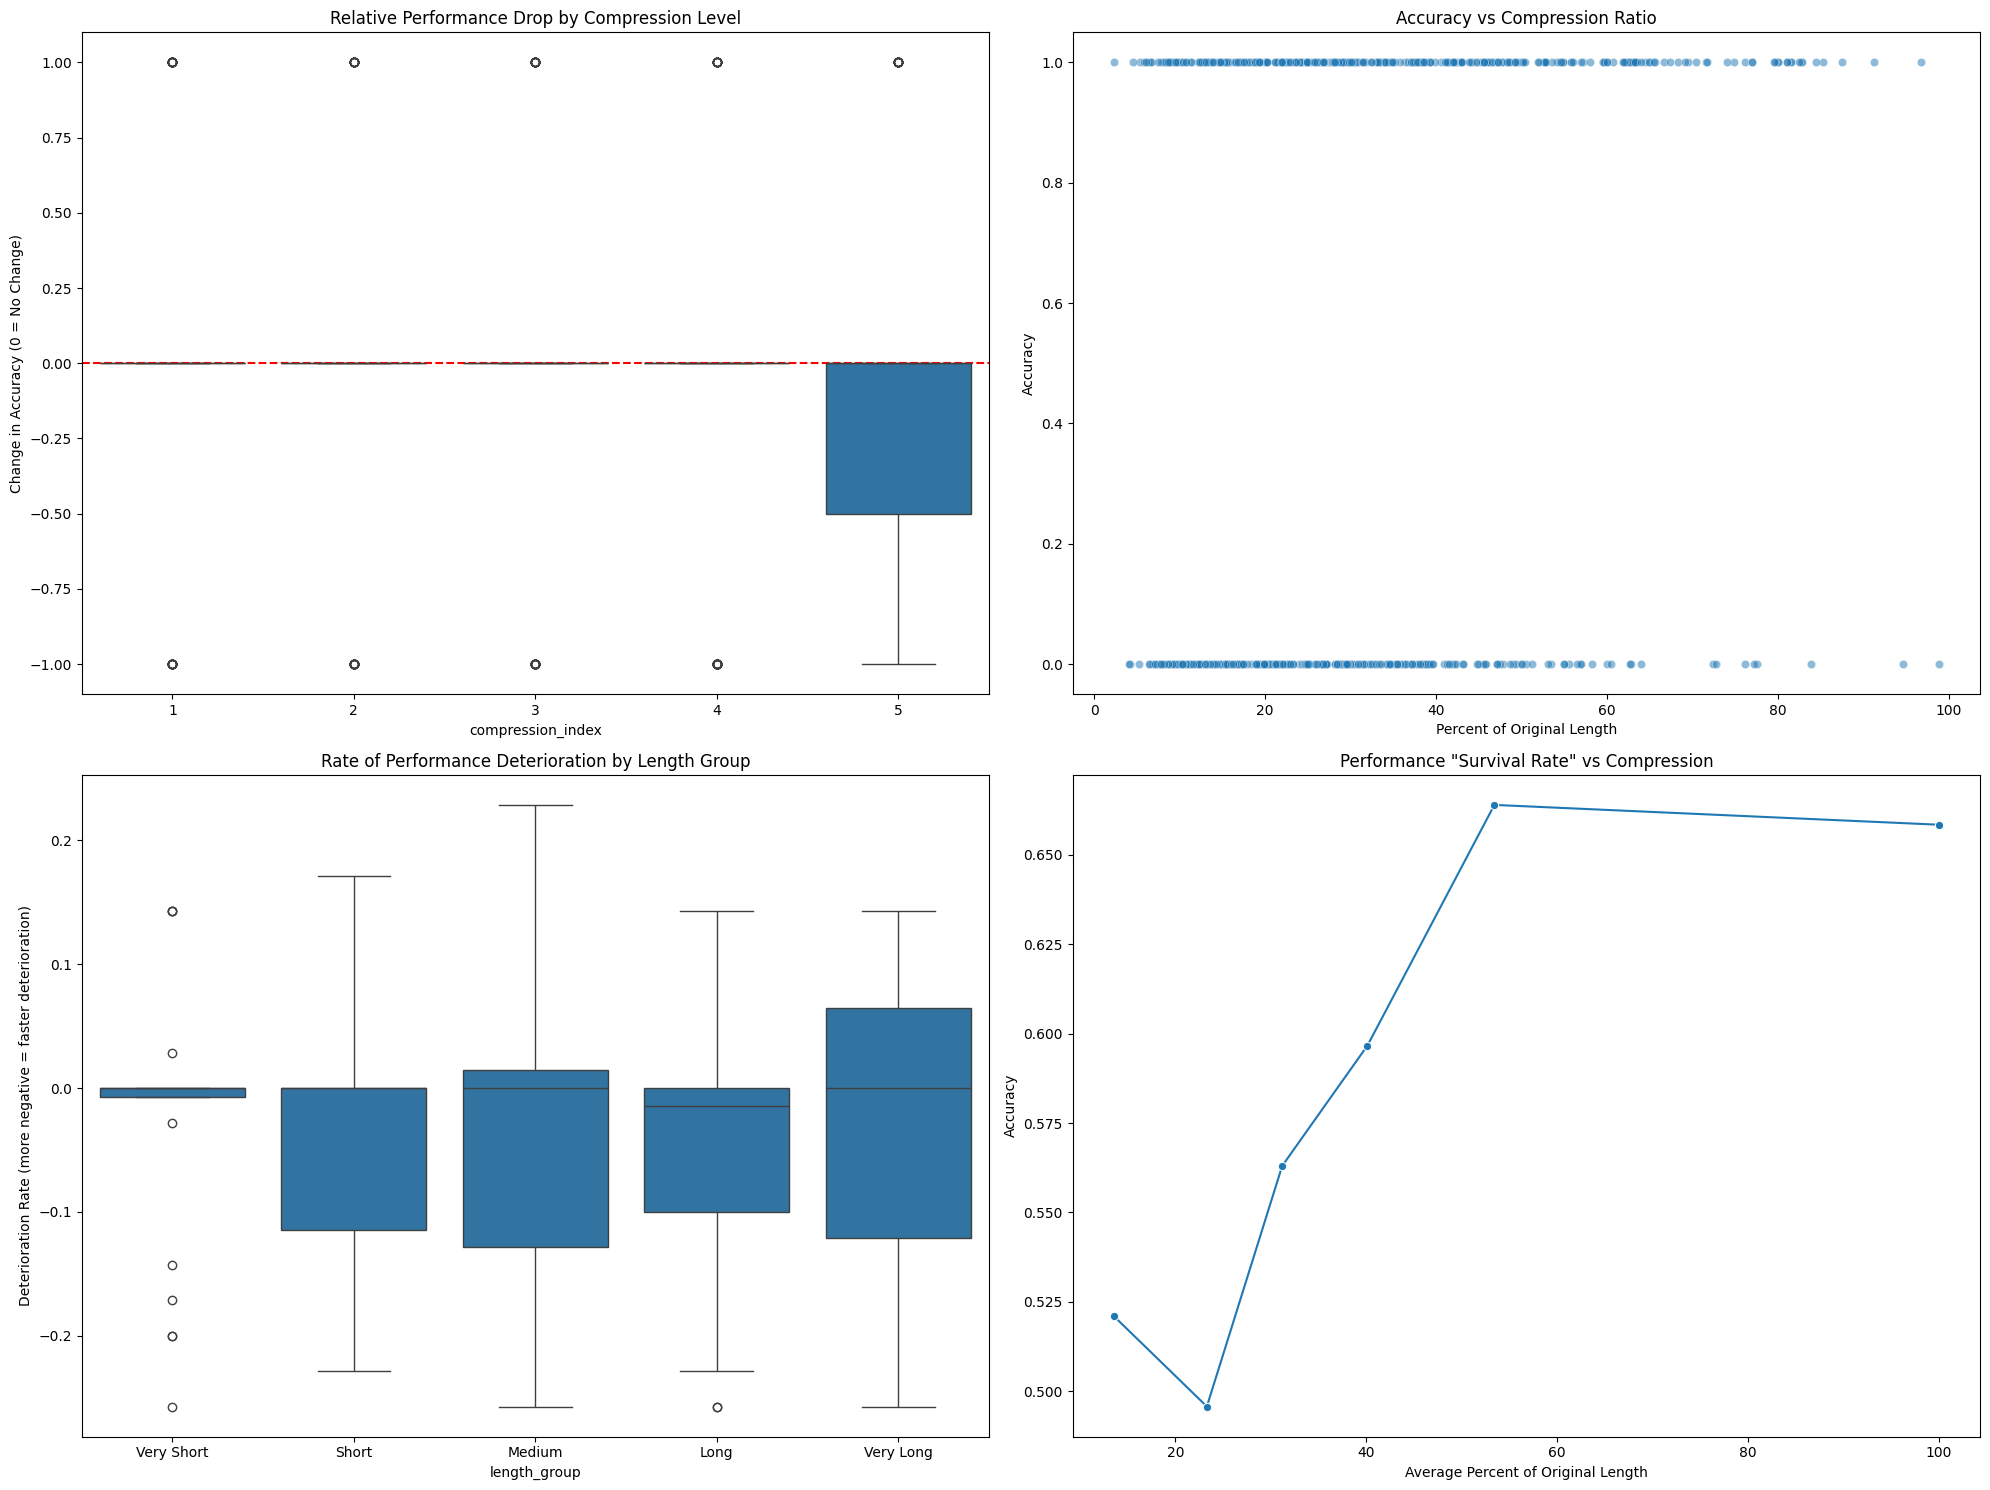


Deterioration Statistics:

Average deterioration rate by length group:
length_group
Very Short   -0.0226
Short        -0.0310
Medium       -0.0335
Long         -0.0560
Very Long    -0.0298
Name: deterioration_rate, dtype: float64

Performance drop at each compression level:
Compression level 1: -0.006 drop from baseline
Compression level 2: 0.062 drop from baseline
Compression level 3: 0.095 drop from baseline
Compression level 4: 0.163 drop from baseline
Compression level 5: 0.137 drop from baseline


/var/folders/pn/ctr6tfqn77556nyp3p9v447r0000gn/T/ipykernel_16813/2521569951.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(deterioration_df.groupby('length_group')['deterioration_rate'].mean().round(4))


In [29]:
# Load data as before
timestamp = "20250130_195708"
dfs = []
for i in range(4):
    df = pd.read_csv(f'../results_{timestamp}_process_{i}.csv')
    df['process_id'] = i
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# Create figure with multiple plots
fig = plt.figure(figsize=(20, 15))

# 1. Relative Performance Drop
ax1 = plt.subplot(2, 2, 1)
# Calculate relative performance drop compared to original
baseline_accuracy = combined_df[combined_df['compression_index'] == 0].groupby('record_id')['is_correct'].first()
relative_performance = combined_df.copy()
relative_performance['baseline_correct'] = relative_performance['record_id'].map(baseline_accuracy)
# Convert boolean to int before subtraction
relative_performance['performance_drop'] = relative_performance['is_correct'].astype(int) - relative_performance['baseline_correct'].astype(int)

sns.boxplot(
    data=relative_performance[relative_performance['compression_index'] > 0],
    x='compression_index',
    y='performance_drop'
)
ax1.set_title('Relative Performance Drop by Compression Level')
ax1.set_ylabel('Change in Accuracy (0 = No Change)')
ax1.axhline(y=0, color='r', linestyle='--')

# 2. Accuracy vs Compression Ratio
ax2 = plt.subplot(2, 2, 2)
sns.scatterplot(
    data=combined_df[combined_df['compression_index'] > 0],
    x='percent_of_original',
    y='is_correct',
    alpha=0.5
)
ax2.set_title('Accuracy vs Compression Ratio')
ax2.set_xlabel('Percent of Original Length')
ax2.set_ylabel('Accuracy')

# 3. Performance Deterioration Rate
ax3 = plt.subplot(2, 2, 3)
# Calculate deterioration rate for each question
deterioration_rates = []
for record_id in combined_df['record_id'].unique():
    question_data = combined_df[combined_df['record_id'] == record_id].sort_values('compression_index')
    if len(question_data) > 1:
        # Calculate slope of accuracy vs compression level
        x = question_data['compression_index']
        y = question_data['is_correct'].astype(float)  # Convert to float for slope calculation
        rate = np.polyfit(x, y, 1)[0]
        deterioration_rates.append({
            'record_id': record_id,
            'deterioration_rate': rate,
            'original_length': question_data['original_char_count'].iloc[0]
        })

deterioration_df = pd.DataFrame(deterioration_rates)
# Create length groups for deterioration analysis
deterioration_df['length_group'] = pd.qcut(
    deterioration_df['original_length'],
    q=5,
    labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
)

sns.boxplot(
    data=deterioration_df,
    x='length_group',
    y='deterioration_rate'
)
ax3.set_title('Rate of Performance Deterioration by Length Group')
ax3.set_ylabel('Deterioration Rate (more negative = faster deterioration)')

# 4. Survival Analysis
ax4 = plt.subplot(2, 2, 4)
# Calculate "survival rate" (questions that maintain accuracy)
survival_data = combined_df.groupby('compression_index').agg({
    'is_correct': 'mean',
    'percent_of_original': 'mean'
}).reset_index()

sns.lineplot(
    data=survival_data,
    x='percent_of_original',
    y='is_correct',
    marker='o'
)
ax4.set_title('Performance "Survival Rate" vs Compression')
ax4.set_xlabel('Average Percent of Original Length')
ax4.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nDeterioration Statistics:")
print("\nAverage deterioration rate by length group:")
print(deterioration_df.groupby('length_group')['deterioration_rate'].mean().round(4))

print("\nPerformance drop at each compression level:")
for idx in range(1, 6):
    baseline = combined_df[combined_df['compression_index'] == 0]['is_correct'].mean()
    compressed = combined_df[combined_df['compression_index'] == idx]['is_correct'].mean()
    print(f"Compression level {idx}: {(baseline - compressed):.3f} drop from baseline")

Index(['record_id', 'compression_index', 'question_id', 'question',
       'predicted_letter', 'predicted_answer', 'correct_letter',
       'correct_answer', 'is_correct', 'original_char_count',
       'compressed_char_count', 'percent_of_original', 'process_id'],
      dtype='object')

In [33]:

# Load results data
timestamp = "20250130_195708"
dfs = []
for i in range(4):
    df = pd.read_csv(f'../results_{timestamp}_process_{i}.csv')
    df['process_id'] = i
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# Load GPQA diamond dataset
gpqa_df = pd.read_csv('../datasets/gpqa_diamond.csv')

# Merge datasets
merged_df = combined_df.merge(
    gpqa_df[['Record ID', 'Domain', 'Subdomain']], 
    left_on='record_id',
    right_on='Record ID',
    how='left'
)

# Create figure with multiple plots
fig = plt.figure(figsize=(20, 15))

# 1. Performance Drop by Domain
ax1 = plt.subplot(2, 2, 1)
sns.lineplot(
    data=merged_df,
    x='compression_index',
    y='is_correct',
    hue='Domain',
    marker='o',
    ci=95
)
ax1.set_title('Accuracy by Domain and Compression Level')
ax1.set_xlabel('Compression Level')
ax1.set_ylabel('Accuracy')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Relative Performance Drop by Domain
ax2 = plt.subplot(2, 2, 2)
baseline_accuracy = merged_df[merged_df['compression_index'] == 0].groupby('record_id')['is_correct'].first()
relative_performance = merged_df.copy()
relative_performance['baseline_correct'] = relative_performance['record_id'].map(baseline_accuracy)
relative_performance['performance_drop'] = relative_performance['is_correct'].astype(int) - relative_performance['baseline_correct'].astype(int)

sns.boxplot(
    data=relative_performance[relative_performance['compression_index'] > 0],
    x='compression_index',
    y='performance_drop',
    hue='Domain'
)
ax2.set_title('Performance Drop by Domain')
ax2.set_ylabel('Change in Accuracy (0 = No Change)')
ax2.axhline(y=0, color='r', linestyle='--')

# 3. Heatmap of Domain Performance
ax3 = plt.subplot(2, 2, 3)
heatmap_data = merged_df.pivot_table(
    values='is_correct',
    index='Domain',
    columns='compression_index',
    aggfunc='mean'
)
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0.5,
    vmin=0,
    vmax=1
)
ax3.set_title('Accuracy Heatmap by Domain and Compression Level')

# 4. Subdomain Analysis
ax4 = plt.subplot(2, 2, 4)
# Get top N subdomains by number of questions
top_subdomains = merged_df[merged_df['compression_index'] == 0]['Subdomain'].value_counts().head(8).index
subdomain_data = merged_df[merged_df['Subdomain'].isin(top_subdomains)]

sns.lineplot(
    data=subdomain_data,
    x='compression_index',
    y='is_correct',
    hue='Subdomain',
    marker='o',
    ci=95
)
ax4.set_title('Accuracy by Top Subdomains')
ax4.set_xlabel('Compression Level')
ax4.set_ylabel('Accuracy')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nPerformance Deterioration by Domain:")
for domain in merged_df['Domain'].unique():
    domain_data = merged_df[merged_df['Domain'] == domain]
    baseline = domain_data[domain_data['compression_index'] == 0]['is_correct'].mean()
    print(f"\n{domain}:")
    print(f"Baseline accuracy: {baseline:.3f}")
    for idx in range(1, 6):
        compressed = domain_data[domain_data['compression_index'] == idx]['is_correct'].mean()
        drop = baseline - compressed
        print(f"Compression {idx}: {drop:.3f} drop ({compressed:.3f} accuracy)")

# Calculate "resilience score" by domain
print("\nDomain Resilience Scores (average performance retention):")
domain_resilience = []
for domain in merged_df['Domain'].unique():
    domain_data = merged_df[merged_df['Domain'] == domain]
    baseline = domain_data[domain_data['compression_index'] == 0]['is_correct'].mean()
    compressed_accuracy = domain_data[domain_data['compression_index'] > 0]['is_correct'].mean()
    resilience_score = compressed_accuracy / baseline if baseline > 0 else 0
    domain_resilience.append({
        'Domain': domain,
        'Resilience': resilience_score,
        'Baseline': baseline,
        'Compressed': compressed_accuracy
    })

resilience_df = pd.DataFrame(domain_resilience).sort_values('Resilience', ascending=False)
print(resilience_df.round(3))

KeyError: "['Domain'] not in index"